# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [111]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [286]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Looks we had some trouble while importing already with some features that have mixed types values

In [244]:
# These two featutres have mixed type float and string
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [246]:
azdias.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [114]:
azdias.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [115]:
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

This shows a problem with this table where there are same values that are different because of the type either int or fload

So the values X and XX in these two tables are to be considered "unknown" and converted to null. So in our initial cleaning we will check the values of the documented features against the documentation ( the "DIAS Attributes - Values 2017.xlsx" file) and consider the ones that fall outside the reanges priveded as null.


In [287]:
# Reading the features description excel file into a Dataframe
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', index_col=[0, 1, 2]).reset_index()
feat_info.drop('level_0', axis=1, inplace=True)
feat_info_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', index_col=[0, 1]).reset_index()
feat_info_levels.drop('level_0', axis=1, inplace=True) 

feat_info_levels.head()
feat_info[feat_info.Attribute=='CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [288]:
# Turns out the feat_info dataset from the Excel spreadsheet has some columns that are not in the population dataset
# and vicecersa, Let's explore a bit
# These one are in the population and are described in the spreadsheet
attributes_we_have_info_about = np.intersect1d(feat_info.Attribute.unique(), np.array(azdias.columns))
# These one are in the population and are NOT described in the spreadsheet
attributes_we_dont_have_info = np.setdiff1d(np.array(azdias.columns), feat_info.Attribute.unique())
# These one are in the spreadsheet and are NOT in the population so we just ignore them for now
attributes_we_dont_care = np.setdiff1d(feat_info.Attribute.unique(), np.array(azdias.columns))

len(attributes_we_have_info_about), len(attributes_we_dont_have_info), len(attributes_we_dont_care)

(270, 96, 42)

In [365]:
# we can build a dataframe with atributes and type plus description of unknown values 
print(feat_info.Attribute.nunique())
unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known', 'numeric value (typically coded from 1-10)',
                 'numeric value (typically coded from 1-3)', 'no transaction known']
dias_info =  feat_info[feat_info.Meaning.isin(unknown_values)]
# Add the ones who don't have unknown values
for feat in np.setdiff1d(feat_info.Attribute, dias_info.Attribute):
    dias_info = dias_info.append(feat_info[feat_info.Attribute == feat].iloc[0,:2])


# Finally add columns missing if the excel spreadsheet
np.setdiff1d(azdias.columns.values, dias_info.Attribute)
#for column in np.setdiff1d(azdias.columns.values, dias_info.Attribute):
#    dias_info['Attribute'] = column
#len(azdias.columns.values), len(dias_info.Attribute)
#dias_info.Attribute.nunique(), azdias.shape

312


array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST',
       'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG',
       'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_

So we will start handling the features that are documented for now and run some cleaning scripts, then we will explore the undocumented ones and decide what to do with them.

In [289]:
# Check values for a random feature
# split a string is a string otherwise return unchanged
def split_if_string(x):
    if isinstance(x, str):
        return x.split(',')
    else:
        return x
# Change ints into floats in a list and leave anything else unchanged
def to_float(x):
    try:
        x = float(x)
    except:
        pass
    return x

In [290]:
# The numerical features need to be handled separately, as there are some 0s
numerical_features = ['ANZ_HAUSHALTE_AKTIV', 'GEBURTSJAHR', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
                     'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
# ANZ_HAUSHALTE_AKTIV: Number of households in the building, 6463 data points have value=0, we keep them
# GEBURTSJAHR: Year of birth: 0 is to be considered null
# ANZ_HH_TITEL: number of academic title holder in building: 0 is acceptable, but there are 770244 data points with zero, we set them to null
# ANZ_PERSONEN: number of adult persons in the household: 0 not acceptable and there are 34103 with this value (we put null)
# ANZ_TITEL: number of professional title holder in household: 0 is acceptabl, 814542 data points have zero, we set them to null
# KBA13_ANZAHL_PKW: number of cars in the PLZ8 => 0 is ok
# MIN_GEBAEUDEJAHR: year the building was first mentioned in our database => 0 is null

def fix_numerical_features(df):
    d = {0 : np.nan}
    df['GEBURTSJAHR'] = df['GEBURTSJAHR'].replace(d)
    df['MIN_GEBAEUDEJAHR'] = df['MIN_GEBAEUDEJAHR'].replace(d)
    df['ANZ_PERSONEN'] = df['ANZ_PERSONEN'].replace(d)
    df['ANZ_TITEL'] = df['ANZ_TITEL'].replace(d)
    df['ANZ_HH_TITEL'] = df['ANZ_HH_TITEL'].replace(d)
    return df
azdias = fix_numerical_features(azdias)

In [291]:
# Now we will look for "undocumented" null values, that are not included in the spreadsheet

attributes_to_check = np.setdiff1d(attributes_we_have_info_about, numerical_features)
# we can generalize adding all the d19 columns
d19_cols = []
for column in azdias.columns.values:
    if "D19" in column:
        d19_cols.append(column)


# Better align values first as it is taking as different int and floats

def check_all_values(df, feat_info):
    for attribute in attributes_to_check:
        theoretical_vals = feat_info[feat_info.Attribute == attribute].Value.apply(lambda x: split_if_string(x)).values
        theoretical_vals = np.hstack(theoretical_vals)
        theoretical_vals = [to_float(x) for x in theoretical_vals]
        actual_values = df.loc[:, attribute].value_counts().index.values
        actual_values = [to_float(x) for x in actual_values]
        diff = set(actual_values) - set(theoretical_vals)
        if diff != set():
            print('Attribute {} has undocumented values {}'.format(attribute, diff))

check_all_values(azdias, feat_info)

Attribute CAMEO_DEUG_2015 has undocumented values {'X'}
Attribute CAMEO_DEU_2015 has undocumented values {'XX'}
Attribute KBA05_MODTEMP has undocumented values {6.0}
Attribute LP_FAMILIE_FEIN has undocumented values {0.0}
Attribute LP_FAMILIE_GROB has undocumented values {0.0}
Attribute LP_LEBENSPHASE_FEIN has undocumented values {0.0}
Attribute LP_LEBENSPHASE_GROB has undocumented values {0.0}
Attribute ORTSGR_KLS9 has undocumented values {0.0}


So here we have:

CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup => X is null

CAMEO_DEU_2015: most common building-type within the cell => XX is a null

KBA05_MODTEMP: development of the most common car segment in the neighbourhood: we keep 6.0 although it's not documented

LP_FAMILIE_FEIN: familytyp fine: 0 is a null, must be between 1 to 11

LP_FAMILIE_GROB familytyp rough, must be 1 to 11, so 0 is a null

LP_LEBENSPHASE_FEIN: lifestage fine, must be 1 to 40, so 0 is a null

LP_LEBENSPHASE_GROB: lifestage rough, must be 1 to 12, so 0 is  a null

ORTSGR_KLS9: size of the community, 1 to 9, so 0 is a null


Now we know which columns contain values that are unknown when the "Meaning" in the dataframe has the value "unknown".
We leave the features that have a value equal to zero with Meaning "no transaction known"as they represent transactional activity over a period, so we interpret is as "zero transactions".
Then there is an additional group of features 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL' that are must be analyzed separately as a zero value is equal to null for some of them.


In [306]:
d19_cols = []
for column in azdias.columns.values:
    if "D19" in column:
        d19_cols.append(column)
np.setdiff1d(d19_cols, feat_info.Attribute.unique())
# CAreful with these ones as 0 does not necessarily means unknown

array(['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST',
       'D19_VERSICHERUNGEN', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST'], dtype='<U27')

In [292]:
# Check also the KBA05 and KBA13 columns
kba05 = [] # this ones have -1 or 9 as unknown
kba13 = [] # this ones have -1 as unkmnown
for column in azdias.columns.values:
    if "KBA05" in column:
        kba05.append(column)
for column in azdias.columns.values:
    if "KBA13" in column:
        kba13.append(column)
np.setdiff1d(kba05, feat_info.Attribute.unique()), np.setdiff1d(kba13, feat_info.Attribute.unique())
d19_cols = []
for column in azdias.columns.values:
    if "D19" in column:
        d19_cols.append(column)
        

(array(['KBA05_BAUMAX'], dtype='<U15'),
 array(['KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4',
        'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ',
        'KBA13_KMH_210'], dtype='<U27'))

In [307]:
def fix_undocumented_nulls(df):
    dx = {'X':np.nan}
    dxx = {'XX':np.nan}
    d0 = {0:np.nan}
    dkba05 = {-1:np.nan, 9:np.nan}
    dkba13 = {-1:np.nan}
    d19 = {0:np.nan}
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace(dx)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(dxx)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(dxx)
    df['LP_FAMILIE_FEIN'] = df['LP_FAMILIE_FEIN'].replace(d0)
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].replace(d0)
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace(d0)
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(d0)
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace(d0)
    
    for feat in np.setdiff1d(kba05, feat_info.Attribute.unique()):
        df[feat] = df[feat].replace(dkba05)
    for feat in np.setdiff1d(kba13, feat_info.Attribute.unique()):
        df[feat] = df[feat].replace(dkba13)
    # Not sure about those
    #for feat in np.setdiff1d(d19_cols, feat_info.Attribute.unique()):
        #df[feat] = df[feat].replace(d19)
    #return df

azdias = fix_undocumented_nulls(azdias) 

In [294]:
unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known']
unknown_values_df = feat_info[(feat_info.Attribute.isin(attributes_to_check) & 
                              (feat_info.Meaning.isin(unknown_values)))]

In [236]:
attribute='D19_BANKEN_ANZ_12'
#azdias.D19_BANKEN_ANZ_12.value_counts()
d = {0:np.nan}
#azdias.loc[azdias[attribute] == 0, attribute]
azdias['D19_BANKEN_ANZ_12'] = azdias['D19_BANKEN_ANZ_12'].replace(d)
#

In [295]:
# Now we can convert the documented missing Value Codes to NaNs. Not all columns in the population dataset are included in the informational spreadsheets
# This will take a while for the population dataset
import progressbar

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def convert_unknown(df, unknown_values_df):
    
    n_iters = unknown_values_df.shape[0]
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_iters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for _, row in unknown_values_df.iterrows():
        if isinstance(row.Value, str):
            d = {}
            for unknown_value in row.Value.split(','):
                d[float(unknown_value)] = np.nan
            df[row.Attribute] = df[row.Attribute].replace(d)
        else:
            d = {row.Value : np.nan}
            df[row.Attribute] = df[row.Attribute].replace(d)
        cnter+=1 
        bar.update(cnter)
    
    bar.finish()            
    return df

unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known']
unknown_values_df = feat_info[(feat_info.Attribute.isin(attributes_to_check) & 
                              (feat_info.Meaning.isin(unknown_values)))]
azdias = convert_unknown(azdias, unknown_values_df)

[========================================================================] 100%


In [296]:
# Now we can have a look at the float vs int problem in the categorical features we had at the beginning
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

In [297]:
# Now we can save it
azdias.to_feather('azdias_nulls.feather')

### Choosing columns to drop
We will analyze the amount of missing data and choose which columns to drop.
Additionally some columns may be dropped for tyher reasons, for example:
- if they have unique values
- if they are categorical values with too many different values, for example more than 10 categories
- when we don't have enough information to decide how to encode them
- features that are a possible source of ethical bias

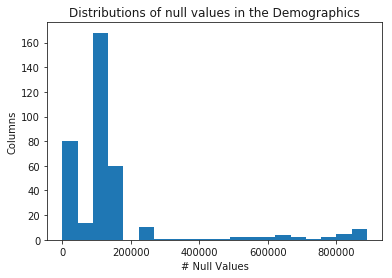

In [258]:
# Assess missing data in columns
plt.hist(azdias.isnull().sum(), bins=20)
plt.title('Distributions of null values in the Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Columns');

In [308]:
# Investigate patterns in the amount of missing data in each column.
columns = azdias.isnull().sum().sort_values(ascending=False)
#[(columns, nulls) for columns, nulls in columns.items() if nulls > 0]


Text(0.5,1,'Attributes with more than 30% of missing values')

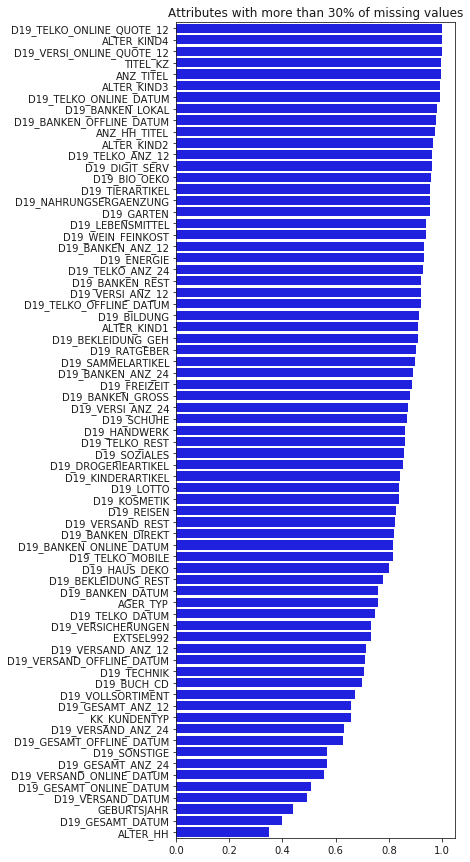

In [311]:
percent_missing = columns/azdias.shape[0]
data = percent_missing[percent_missing > 0.3]
plt.figure(figsize=(5,15))
sns.barplot(y=data.index, x=data.values, orient='h', color='blue')
plt.title("Attributes with more than 30% of missing values")

In [312]:
#data.shape
azdias.D19_TELKO_ONLINE_QUOTE_12.value_counts()

10.0    767
5.0      19
7.0       1
3.0       1
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: int64

In [302]:
#The distribution above shows that some outlier features have more thn 250000 null values. 
# Since we will run this script on the customer data set as well, we will use a % of the whole dataset =>28%
# Considering the dataset has 891221 data points, we can select those ones candidates features to be dropped
columns_to_drop = [s for s, v in (azdias.isnull().sum() > azdias.shape[0] * 0.3).items() if v]
print(columns_to_drop)
#azdias.drop(columns_to_drop, axis=1, inplace=True)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_HH_TITEL', 'ANZ_TITEL', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ']


In [269]:
len(columns_to_drop)



34

In [134]:
# Let's have a look at the undocumented features: most of them are categorical, we don;t have information about the required values
# We can look for usually null value equivalents like -1 or 'X' or 'XX', but there are none of those 
np.setdiff1d(attributes_we_dont_have_info, columns_to_drop)

#(azdias[attributes_we_dont_have_info]=='XX').sum().sum(), (azdias[attributes_we_dont_have_info]==-1).sum().sum(), 
#(azdias[attributes_we_dont_have_info]=='X').sum().sum()

array(['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT',
       'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
       'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_DATUM',
       'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_F

Column with unique values

In [135]:
# Columns with unique values, doesn't give any information
azdias.LNR.value_counts().shape

(891221,)

In [136]:
# So we will drop it
azdias.drop('LNR', axis=1, inplace=True)

Features that are a possible source of ethical bias

In [137]:
# NATIONALITAET_KZ: possible source of ethical bias
azdias.drop('NATIONALITAET_KZ', axis=1, inplace=True)

Exploring Categiorical Features with Multi-values

In [146]:
# Categorical Multi-values with too many values
multi_categorical_too_many_values = ['CAMEO_DEU_2015','GFK_URLAUBERTYP','LP_LEBENSPHASE_FEIN', 'VERDICHTUNGSRAUM']
# two of those have already been dropped
azdias.drop(multi_categorical_too_many_values, axis=1, inplace=True)


In [157]:
# Let's have a look at the other categorical features
categorical_features = np.setdiff1d(azdias.columns.values, numerical_features)
azdias['AKT_DAT_KL'].value_counts().shape[0]

for categ in categorical_features:
    num_categs = azdias[categ].value_counts().shape[0]
    if num_categs > 10:
        print("Feature {} has {} categories".format(categ, num_categs))

    

Feature ANZ_KINDER has 11 categories
Feature ANZ_STATISTISCHE_HAUSHALTE has 268 categories
Feature CAMEO_INTL_2015 has 21 categories
Feature EINGEZOGENAM_HH_JAHR has 37 categories
Feature LP_FAMILIE_FEIN has 11 categories
Feature LP_LEBENSPHASE_GROB has 12 categories
Feature PRAEGENDE_JUGENDJAHRE has 15 categories
Feature VK_DHT4A has 11 categories
Feature VK_DISTANZ has 13 categories
Feature VK_ZG11 has 11 categories


In [166]:
#azdias.ANZ_KINDER.value_counts()
# 731242 zeros-> we drop it
#azdias.ANZ_STATISTISCHE_HAUSHALTE.value_counts()
# No information from the spreadsheets, drop?
azdias.EINGEZOGENAM_HH_JAHR.value_counts()
# Looks like a year related information, we keep it as it is
azdias.LP_FAMILIE_FEIN.value_counts()
# Family type, we will hot-encode it
azdias.LP_LEBENSPHASE_GROB.value_counts()
# Ordinal, we keep it
#CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE we will re-engineer them
azdias.VK_DHT4A.value_counts()
# Looks ordinal
azdias.VK_DISTANZ.value_counts()
# Looks ordinal
azdias.VK_ZG11.value_counts()
# Looks ordinal

10.0    97938
5.0     97777
6.0     88581
7.0     88552
4.0     86600
8.0     83994
9.0     82134
3.0     69634
2.0     59916
1.0     52009
11.0     8169
Name: VK_ZG11, dtype: int64

In [167]:
# So we have 2 more columns to drop
drop_these_ones_too = ['ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']
azdias.drop(drop_these_ones_too, axis=1, inplace=True)

In [168]:
# Saving
azdias.to_feather('azdias.feather')

In [23]:
azdias = pd.read_feather('azdias.feather')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Text(0,0.5,'Rows')

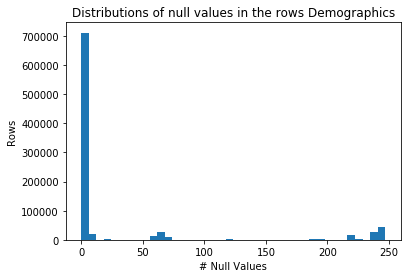

In [11]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

In [17]:
# We can see that the large majority of the population has less than 50 null fatures.
# we can remove the datapoints with more than 50 nulls in each row

azdias.dropna(thresh=azdias.shape[1] - 50, inplace=True)

Text(0,0.5,'Rows')

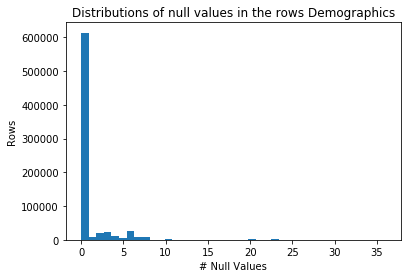

In [18]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

### Features Re-encoding
Some categorical features need re-encoding. We will look at the spreadsheet to choose which ones to re-encode.
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling will be necessary for the remaining two variable types: categorical, and 'mixed'.

Are there binary categorical features that need re-encoding?
Are there multi-level categorical features that need re-encoding?


In [57]:
# Binary categorical features
# OST_WEST_KZ: flag indicating the former GDR/FRG
#azdias['OST_WEST_KZ'].value_counts()

ost_west_dict = {'OST_WEST_KZ': {'W':0, 'O':1}}
azdias.replace(ost_west_dict, inplace=True)


W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

Multi-level categoricals (three or more values) will be one-hot encoded using multiple dummy variables.

In [71]:
# Multi value features 
columns_to_reencode=['FINANZTYP', 'CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                      'ZABEOTYP', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'CAMEO_DEUG_2015', 
                      'SHOPPER_TYP', 'LP_FAMILIE_GROB','LP_FAMILIE_FEIN']
#azdias[columns_to_reencode].head()
azdias.ALTER_HH.value_counts()

0.0     236768
18.0     60852
17.0     55665
19.0     52890
15.0     51867
16.0     51857
14.0     44275
21.0     41610
20.0     40671
13.0     37612
12.0     34923
10.0     30419
11.0     27924
9.0      22817
8.0      13463
7.0       8419
6.0       3809
5.0       1030
4.0        603
3.0        200
2.0         47
1.0          1
Name: ALTER_HH, dtype: int64

In [70]:
# Special cases: Mixed-Type Features
#LP_FAMILIE_GROB, LP_STATUS_GROB, PRAEGENDE_JUGENDJAHRE, CAMEO_DEUINTL_2015, CAMEO_DEU_2015, CAMEO_INTL_2015

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which i
ncludes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')